In [1]:
# Core libraries
import os
import glob
import random
import datetime
import warnings

# Numerical & plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# ECG data handling
import wfdb

# Machine Learning utilities
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

# Deep Learning
import keras
from tensorflow.keras.models import load_model

# Suppress warnings
warnings.simplefilter('ignore')


D:\SLIIT\MIT\venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
DATASET_PATH = './mitdb'
header_path = os.path.join(DATASET_PATH, '*hea')
paths = glob.glob(header_path)

# Remove the extension and store the path
paths = [path[:-4] for path in paths]

# Remove paced beat record
remove_paced_beats = ['102', '104', '107', '217']

# Store the data path
data_paths = [path for path in paths if path[-3:] not in remove_paced_beats]

train_data = ['101', '106', '108', '109', '112', '114', '115', '116', '118', '119', '122',
              '124', '201', '203', '205', '207', '208', '209', '215', '220', '223', '230']

train_data_paths = [path for path in data_paths if path[-3:] in train_data]

test_data = ['100', '103', '105', '111', '113', '117', '121', '123', '200', '202', '210',
             '212', '213', '214', '219', '221', '222', '228', '231', '232', '233', '234']

random.seed(42)
random.shuffle(test_data)
validation_data_paths = [path for path in data_paths if path[-3:] in test_data[:-5]]
test_data_paths = [path for path in data_paths if path[-3:] in test_data[-5:]]

In [3]:
# The beats of interest are:

# class E: contains ventricular escape (E) beats.
# class F: contains fusion of ventricular and normal (F) and fusion of paced and normal (f) beats.
# class N: contains normal beat (N), left bundle branch block (L), right bundle branch block (R), atrial premature (A), aberrated atrial premature (a), nodal premature (J), supraventricular premature (S), atrial escape (e) and nodal escape (j) beats.
# class V: contains premature ventricular contraction (V) beats.

In [4]:
# Generate 50 sequences from both sides of the sample

def sequences(symbol, signal, sample, signal_length):
    non_beat_annotations = ["[", "!", "]", "x", "(", ")", "p", "t", "u", "`", "'",
                        "^", "|", "~", "+", "s", "T", "*", "D", "=", '"', "@"]

    # Following beats are considered for the analysis
    beat_annotations = ["N", "L", "R", "A", "a", "J", "S", "V", "F", "e", "j", "E", "f"]

    start = sample - 50
    end = sample + 50

    if symbol in beat_annotations and start > 0 and end < signal_length:
        signal_lead_0 = signal[start:end,0].reshape(1,-1,1)
        signal_lead_1 = signal[start:end,1].reshape(1,-1,1)

        return signal_lead_0,signal_lead_1,symbol

    else:
        return [], [], []

In [5]:
# Scale the data
def preprocess(signal):
    scaler = StandardScaler()
    scaled_signal = scaler.fit_transform(signal)
    return scaled_signal

In [6]:
# Train, Validation and Test data and labels

def generate_data(path):
    signal_channel_0 = []
    signal_channel_1 = []
    labels_channel_0 = []
    labels_channel_1 = []

    for file in path:
        # Load the ECG signal from 2 leads
        record = wfdb.rdrecord(file)

        # Check the frequency is 360
        assert record.fs == 360, 'sample frequency is not 360'
        scaled_signal = preprocess(record.p_signal)
        signal_length = scaled_signal.shape[0]
        annotation = wfdb.rdann(file, 'atr')
        samples = annotation.sample
        symbols = annotation.symbol

        N = ['.', 'N', 'L', 'R', 'A', 'a', 'J', 'S', 'e', 'j']

        for i, sample in enumerate(samples):
            signal_0, signal_1, valid_label = sequences(symbols[i], scaled_signal, sample, signal_length)
            signal_channel_0.extend(signal_0)
            signal_channel_1.extend(signal_1)

            if valid_label != []:

                if valid_label in N:
                    label = 'N'
                else:
                    label = valid_label

                labels_channel_0.append(label)
                labels_channel_1.append(label)

    signals = np.vstack((signal_channel_0,signal_channel_1))
    labels_channel_0_array = np.array([labels_channel_0]).reshape(-1,1)
    labels_channel_1_array = np.array([labels_channel_1]).reshape(-1,1)
    labels = np.vstack((labels_channel_0_array,labels_channel_1_array))

    return signals, labels

In [7]:
# Train, Validation and Test data and labels

train_signals, train_labels = generate_data(train_data_paths)
validation_signals, validation_labels = generate_data(validation_data_paths)
test_signals, test_labels = generate_data(test_data_paths)

In [8]:
# One hot encoding of labels

label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse_output=False)

train_labels_numerical = label_encoder.fit_transform(train_labels.reshape(-1,1))
train_labels_encoded = one_hot_encoder.fit_transform(train_labels_numerical.reshape(-1,1))

validation_labels_numerical = label_encoder.transform(validation_labels.reshape(-1,1))
validation_labels_encoded = one_hot_encoder.transform(validation_labels_numerical.reshape(-1,1))

test_labels_numerical = label_encoder.transform(test_labels.reshape(-1,1))
test_labels_encoded = one_hot_encoder.transform(test_labels_numerical.reshape(-1,1))

In [9]:
print(label_encoder.classes_)

['E' 'F' 'N' 'V']


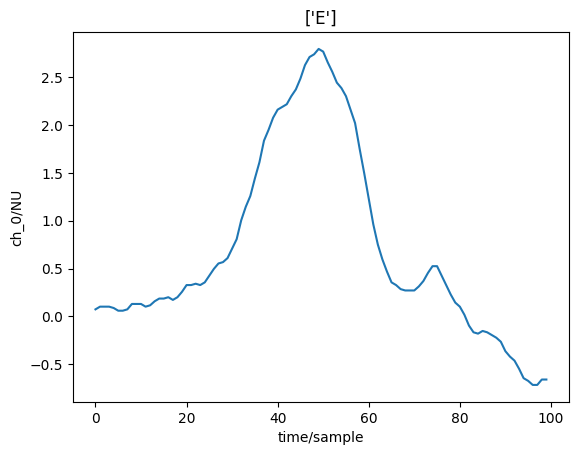

In [10]:
wfdb.plot.plot_items(train_signals[34570], title=train_labels[34570])

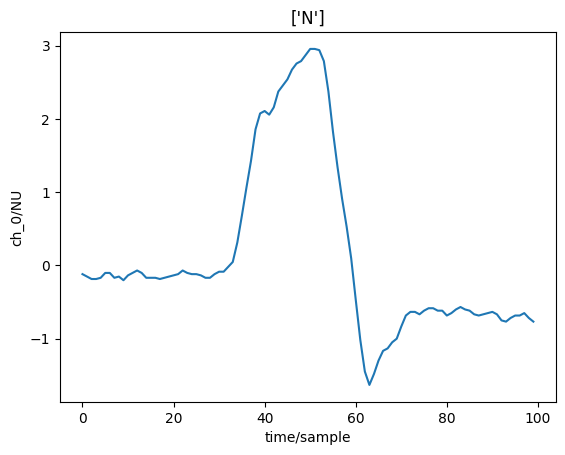

In [11]:
wfdb.plot.plot_items(train_signals[4362], title=train_labels[4362])

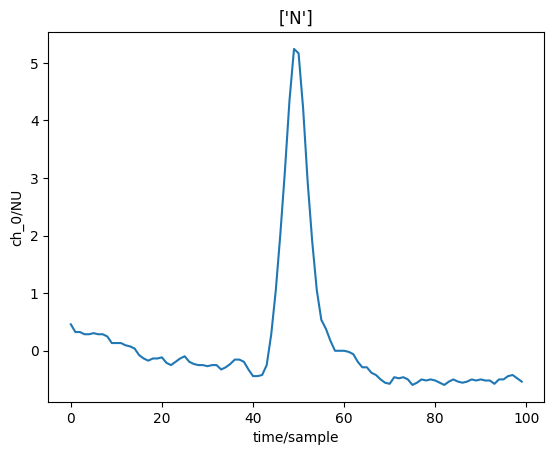

In [12]:
wfdb.plot.plot_items(train_signals[0], title=train_labels[0])

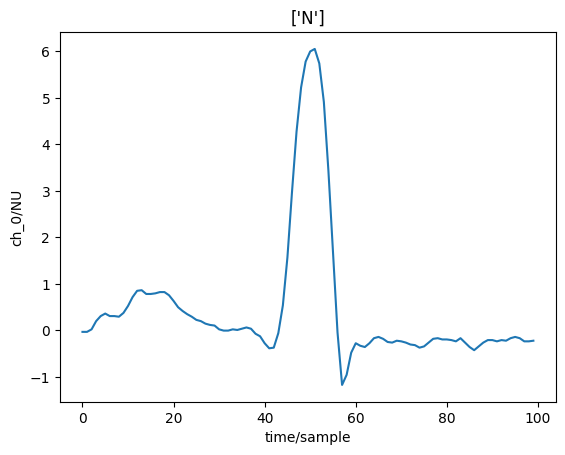

In [13]:
wfdb.plot.plot_items(train_signals[1967], title=train_labels[1967])

In [14]:
#Generator
def generator(X, y, batch_size):
    num_batches = len(X)//batch_size
    while True:
        np.random.seed(100)
        shuffle_sequence = np.random.permutation(len(X))
        X = X[shuffle_sequence]
        y = y[shuffle_sequence]

        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,100,1))
            batch_labels = np.zeros((batch_size,4))

            for folder in range(batch_size):
                batch_data[folder,:,:] = X[folder + (batch*batch_size),:,:]
                batch_labels[folder,:] = y[folder + (batch*batch_size),:]
            yield batch_data.reshape(batch_size,1,100,1), batch_labels.reshape(batch_size,4)


        if (len(X)%batch_size != 0):
            batch_size = len(X) % batch_size

            batch_data = np.zeros((batch_size,100,1))
            batch_labels = np.zeros((batch_size,4))

            for folder in range(batch_size):
                batch_data[folder,:,:] = X[folder + (num_batches*batch_size),:,:]
                batch_labels[folder,:] = y[folder + (num_batches*batch_size),:]
            yield batch_data.reshape(batch_size,1,100,1), batch_labels.reshape(batch_size,4)

In [15]:
print('Shape of train data:', train_signals.shape)
print('Shape of train labels:', train_labels_encoded.shape)
print('Shape of validation data:', validation_signals.shape)
print('Shape of validation labels:', validation_labels_encoded.shape)
print('Shape of test data:', test_signals.shape)
print('Shape of test labels:', test_labels_encoded.shape)

Shape of train data: (117792, 100, 1)
Shape of train labels: (117792, 4)
Shape of validation data: (88182, 100, 1)
Shape of validation labels: (88182, 4)
Shape of test data: (27636, 100, 1)
Shape of test labels: (27636, 4)


In [16]:
batch_size = 2048
train_generator = generator(train_signals, train_labels_encoded, batch_size)
val_generator = generator(validation_signals, validation_labels_encoded, batch_size)

In [17]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Flatten, TimeDistributed, BatchNormalization, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
model = Sequential()

model.add(TimeDistributed(Conv1D(32, 5, activation='elu'), input_shape=(None, 100, 1)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling1D(8, strides=1)))

model.add(TimeDistributed(Conv1D(32, 5, activation='elu'), input_shape=(None, 100, 1)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling1D(8, strides=1)))


model.add(TimeDistributed(Conv1D(64, 4, activation='elu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling1D(8, strides=1)))

model.add(TimeDistributed(Conv1D(64, 4, activation='elu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling1D(8, strides=1)))


model.add(TimeDistributed(Conv1D(128, 3, activation='elu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling1D(8, strides=1)))

model.add(TimeDistributed(Conv1D(128, 3, activation='elu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling1D(8, strides=1)))


model.add(TimeDistributed(Conv1D(256, 2, activation='elu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling1D(8, strides=1)))

model.add(TimeDistributed(Conv1D(256, 2, activation='elu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling1D(8, strides=1)))


# extract features and dropout
model.add(TimeDistributed(Flatten()))

model.add(TimeDistributed(Dense(256, activation='elu')))


# input to LSTM
model.add(LSTM(256, return_sequences=False, dropout=0.5))


# classifier with sigmoid activation for multilabel
model.add(Dense(4, activation='softmax'))

In [18]:
from keras import optimizers
optimizer = optimizers.Adam()
model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["categorical_accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, None, 96, 32)        │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, None, 96, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, None, 89, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, None, 85, 32)        │           5,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, None, 85, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, None, 78, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, None, 75, 64)        │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, None, 75, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, None, 68, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, None, 65, 64)        │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, None, 65, 64)        │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, None, 58, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_12                  │ (None, None, 56, 128)       │          24,704 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_13                  │ (None, None, 56, 128)       │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_14                  │ (None, None, 49, 128)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_15                  │ (None, None, 47, 128)       │          49,280 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_16                  │ (None, None, 47, 128)       │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_17                  │ (None, None, 40, 128)       │              

 Total params: 2,404,452 (9.17 MB)

 Trainable params: 2,402,532 (9.16 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [19]:
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_signals)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(validation_signals)
print('# validation sequences =', num_val_sequences)
num_epochs = 15# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 117792
# validation sequences = 88182
# epochs = 15


In [20]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [21]:
import os
import datetime
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

curr_dt_time = datetime.datetime.now()

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
if not os.path.exists(model_name):
    os.makedirs(model_name)

# Change the file extension from .h5 to .weights.h5
filepath = model_name + 'model-{epoch:05d}-{loss:.3f}-{categorical_accuracy:.3f}-{val_loss:.3f}-{val_categorical_accuracy:.3f}.weights.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

In [22]:
history = model.fit(x=train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, shuffle=True, initial_epoch=0)
# Removed 'workers=1' and 'use_multiprocessing=False'

Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.8857 - loss: 0.3072
Epoch 1: val_loss improved from None to 1.24190, saving model to model_init_2026-01-0118_57_10.939468/model-00001-0.167-0.946-1.242-0.432.weights.h5

Epoch 1: finished saving model to model_init_2026-01-0118_57_10.939468/model-00001-0.167-0.946-1.242-0.432.weights.h5
58/58 ━━━━━━━━━━━━━━━━━━━━ 242s 4s/step - categorical_accuracy: 0.9464 - loss: 0.1665 - val_categorical_accuracy: 0.4317 - val_loss: 1.2419 - learning_rate: 0.0010
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9762 - loss: 0.0811
Epoch 2: val_loss did not improve from 1.24190
58/58 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - categorical_accuracy: 0.9769 - loss: 0.0790 - val_categorical_accuracy: 0.2163 - val_loss: 3.0880 - learning_rate: 0.0010
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - categorical_accuracy: 0.9763 - loss: 0.0805
Epoch 3: val_loss improved from 1.24190 to 1.20170, saving model to mo

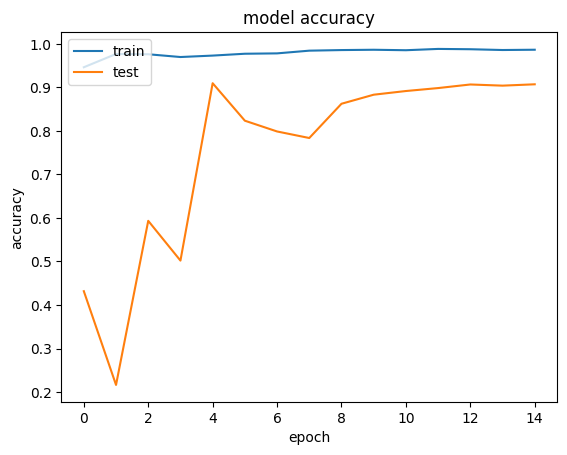

In [23]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

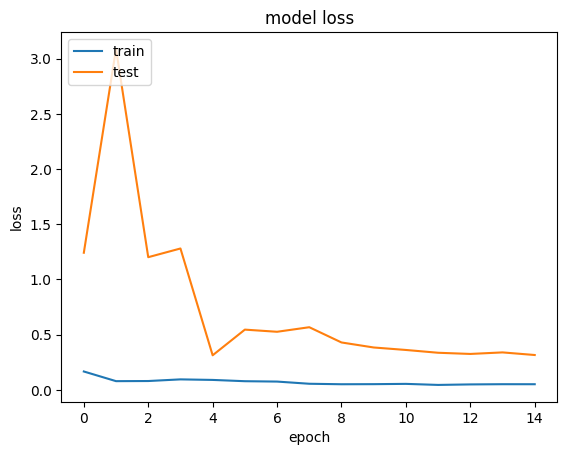

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
train_acc = history.history['categorical_accuracy'][-1]
val_acc = history.history['val_categorical_accuracy'][-1]

print(f"Final Training Accuracy: {train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {val_acc * 100:.2f}%")


Final Training Accuracy: 98.67%
Final Validation Accuracy: 90.73%


In [27]:
print("Train shape:", train_signals.shape)
print("Test shape :", test_signals.shape)


Train shape: (117792, 100, 1)
Test shape : (27636, 100, 1)
